# The Price is Right
Here are some notes and self exploration about the example covering the game "The Price is Right" in chapter 6.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import sys
sys.path.append('/Users/francesco/PersonalProjects/ThinkBayes2/')
from scripts import price

import thinkbayes2
import thinkplot

Given the rules of the game (explained in the book) the questions are:  
1) Before seeing the prizes, what prior beliefs should the contestant have about the price of the showcase? (i.e. what is the prior?)    
2) After seeing the prizes, how should the contestant update those beliefs? (i.e. how do we build a posterior? what is the likelihood?)  
3) Based on the posterior distribution, what should the contestant bid? (this is about the decision, will be investigated later)  

## Prior
The prior is taken from historical data about the prices of the showcases.

In [2]:
dataFolder = '/Users/francesco/PersonalProjects/data/ThinkBayes2/'

In [3]:
dataFiles = [
    'showcases.2011.csv',
    'showcases.2012.csv',
]

In [4]:
data = []
for file in dataFiles:
    data += price.ReadData(dataFolder + file)

In [5]:
df = pd.DataFrame(data, columns=['price1', 'price2', 'bid1', 'bid2', 'diff1', 'diff2'])
len(df)

313

In [6]:
df.head()

,price1,price2,bid1,bid2,diff1,diff2
0,50969,45429,42000,34000,8969,11429
1,21901,34061,14000,59900,7901,-25839
2,32815,53186,32000,45000,815,8186
3,44432,31428,27000,38000,17432,-6572
4,24273,22320,18750,23000,5523,-680


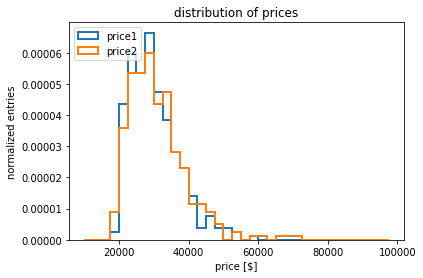

In [7]:
args = {
    'histtype': 'step',
    'linewidth': 2,
    'density': True,
    'grid': False,
    'bins': np.arange(10000, 100000, 2500),
}

df['price1'].hist(label='price1', **args);
df['price2'].hist(label='price2', **args);

plt.title('distribution of prices')
plt.legend(loc=2);
plt.xlabel('price [$]');
plt.ylabel('normalized entries');

The two discrete data distributions are transformed into continuous distributions by taking the kernel density estimation.

In [8]:
p1_kde = thinkbayes2.EstimatedPdf(df['price1'].tolist())
p2_kde = thinkbayes2.EstimatedPdf(df['price2'].tolist())

Transform the KDEs to PMFs.

In [9]:
n = 101
price_xs = np.linspace(0, 75000, n)

p1_pmf = p1_kde.MakePmf(xs=price_xs)
p2_pmf = p2_kde.MakePmf(xs=price_xs)

In [10]:
x1 = [k for k in p1_pmf.d.keys()]
y1 = [p1_pmf.d[k] for k in x1]

x2 = [k for k in p2_pmf.d.keys()]
y2 = [p2_pmf.d[k] for k in x2]

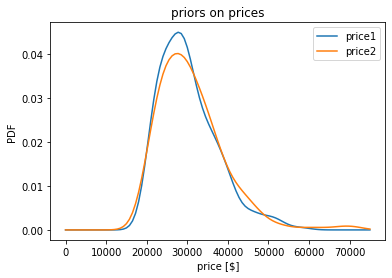

In [11]:
plt.figure()
plt.title('priors on prices')

plt.plot(x1, y1, label='price1');
plt.plot(x2, y2, label='price2');

plt.legend(loc='best')

plt.xlabel('price [$]');
plt.ylabel('PDF');

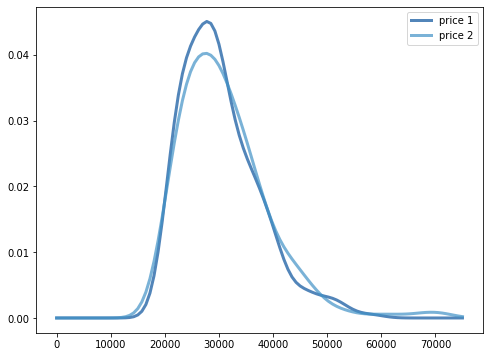

In [12]:
## do the same plot using thinkplot

thinkplot.Clf()
thinkplot.PrePlot(num=2)

p1_pmf.label='price 1'
p2_pmf.label='price 2'

thinkplot.Pdfs([p1_pmf, p2_pmf])
plt.legend();

The two curves are the priors for price 1 and price 2. It is worth noticing that these are priors for the price of each showcase, i.e. these are not P(showcase1) and P(showcase2) (similar to the probabilities of two different hypotheses P(H1) and P(H2)), but the prior is on the price of each individual showcase. In other words, for each showcase there is a set of hypotheses, each representing a price, and each with a given probability.

## Data and Likelihood
We now have the priors, i.e. the probability of the price of each showcase before we see the prizes. After that, the contestant sees the prizes, guesses the price of each prize and sums them up. The sum is the `guess`. In Allen's framing of the problem, the `guess`-es are the data.

It took me a while to realize it, since I was thinking that the prizes are the data and then the process was to get the posterior given the data, i.e. get the value of the price after having seen the prize. "Guessing the value of the price once we see the data" is indeed the what we want to do, but here we are talking about two different levels: in my picture this would have been something like: "what is the price of a showcase containing (e.g.) a car, a guitar and a blender?". This of course could become very complicated and very hard to complete as, e.g., there is a different price for each different car. Allen's framing instead summarizes the showcase in the `price` and the data in the `guess`. "Once the contestant sees the prize and makes his/her guess, what do we know about the price?".

Let's think about the contestant as an instrument to measure the price of the prize: given a prize, i.e. a price, the outcome of the measurement (i.e. what we could actually read on our "instrument") is a guess. That's all the data we have. Then we can wonder about what is the actual price given the guess.

Writing this down in terms of probability, it becomes: P(`price`|`guess`) $\propto$ P(`guess`|`price`)$\times$P(`price`).

This is the context in which section 6.5 of the book is developed. As stated in the book, in order to compute the likelihood, the question we have to answer is: "If the actual price is `price`, what is the likelihood that the contestant's estimate would be guess?", i.e. P(`guess`|`price`) as written in the above formula.

The same question can be addressed in a different way by defining:

`error` = `price` - `guess`

if we consider `error` the above question becomes: "what is the likelihood that the contestant's `guess` is off by `error`?", i.e. P(`error`).

In order to answer this question (i.e. to have a distribution for P(`error`)) historical data are used again: in the data there are 6 different fields, three for each player, `priceX`, `bidX`, `diffX` (`X` = 1, 2). In particular `diff` is the difference between the `price` of the showcase and the `bid` made by the player:

`diff` = `price` - `bid`

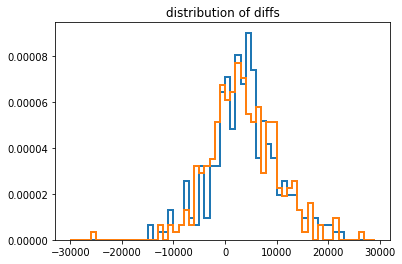

In [13]:
args = {
    'histtype': 'step',
    'linewidth': 2,
    'density': True,
    'grid': False,
    'bins': np.arange(-30000, 30000, 1000),
}



df['diff1'].hist(label='diff1', **args)
df['diff2'].hist(label='diff2', **args)

plt.title('distribution of diffs');


Or we can plot the CDF, as shown in the book:

In [14]:
d1_cdf = thinkbayes2.MakeCdfFromList( df['diff1'].tolist() )
d2_cdf = thinkbayes2.MakeCdfFromList( df['diff2'].tolist() )

In [15]:
x1 = d1_cdf.Values()
y1 = d1_cdf.Probs(x1)

x2 = d2_cdf.Values()
y2 = d2_cdf.Probs(x2)

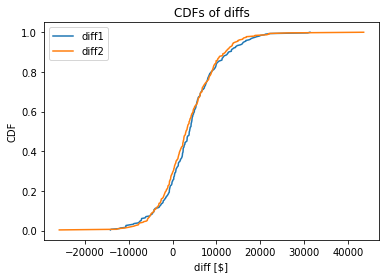

In [16]:
plt.figure()
plt.title('CDFs of diffs');

plt.plot(x1, y1, label='diff1');
plt.plot(x2, y2, label='diff2');

plt.legend(loc='best');
plt.xlabel('diff [$]');
plt.ylabel('CDF');

We can play around with these distribution and find some interesting facts, as written in the book. As and example, the probability of overbidding (i.e. P(`diff` < 0)) for the two players.

In [17]:
d1_cdf.Prob(-1)

0.24600638977635783

In [18]:
d2_cdf.Prob(-1)

0.29073482428115016

It can be seen from the distributions (both the actual distribution and the CDF) `diff`-s are biased, i.e. they are not centered at 0, which makes sense given the rules of the game, i.e. if a contestant overbids he/she looses everything.

In order to proceed with the exercise, i.e. find a distribution for P(`error`), the assumption made in the book is that `error` is normally distributed with mean 0 and same variance as `diff`. As explained in the book this might not be a good assumption, but it is used as an example. It can be of course replaced with whatever other (hopefully better) modelling of P(`error`).

Now that we have a model for P(`error`) it is possible to write down the Likelihood, which is simply the value of a normal distribution (mu, sigma) at the value of `error`, as shown [here](https://github.com/francescolosterzo/ThinkBayes2/blob/master/scripts/price.py#L60) and in the book.

In [19]:
mu = 0

e1_pdf = thinkbayes2.NormalPdf(mu=mu, sigma=np.std(df['diff1']))
e2_pdf = thinkbayes2.NormalPdf(mu=mu, sigma=np.std(df['diff2']))

In [30]:
x1 = e1_pdf.GetLinspace()
y1 = e1_pdf.Density(x1)

x2 = e2_pdf.GetLinspace()
y2 = e2_pdf.Density(x2)

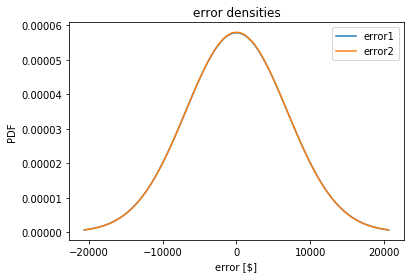

In [32]:
plt.figure()
plt.title('error densities')

plt.plot(x1, y1, label='error1');
plt.plot(x2, y2, label='error2');

plt.legend(loc='best');
plt.xlabel('error [$]');
plt.ylabel('PDF');

Now we can compute the posteriors, given some data, i.e. some `guess`-es. Here we follow the example in the book.

In [33]:
g1 = 20000
g2 = 40000

In [34]:
post1_pmf = p1_pmf.Copy()
post2_pmf = p2_pmf.Copy()